In [1]:
import nltk,re
from nltk import word_tokenize 
import itertools
import numpy as np
import time
import sys
import operator
import io
import os
import array
from six.moves import cPickle as pickle
from datetime import datetime
from gru import GRUTheano
from collections import OrderedDict
import copy
import gzip
import urllib
import random
import stat
import subprocess
import timeit
import theano
from theano import tensor as T

from __future__ import print_function
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.utils.np_utils import accuracy
from keras.models import Graph
from keras.layers.core import Dense, Dropout
import CWEmbedding
from keras.layers.recurrent import LSTM
from sklearn.cross_validation import StratifiedKFold


Using TensorFlow backend.


In [2]:
path='/user/fnoorala/home/Desktop/SMILK/InformationExtraction/data/SemVAl/'

SENTENCE_START_TOKEN = "SENTENCE_START"
SENTENCE_END_TOKEN = "SENTENCE_END"
UNKNOWN_TOKEN = "<UNK>"
word_to_index = []
index_to_word = []
vocabulary_size=8000

def readfiles(filename):
     with open(filename, 'r') as f:
        lines = [line.rstrip('\n') for line in open(filename) 
                 if (len(line.strip())>0 and
                 not line.lower().startswith('comment:'))]
        return lines
    
# find the nominals in the phrase

def extractNominals(mystr):
        nominals=[ match.group(1) for match in re.finditer(r'(<e\d{1}>.*?</e\d{1}>)',mystr)]
        return nominals

def convertToDigit(x):
        t=''
        for i in range(len(x)):
            t += 'DIGIT'
        return t       
# find the order of the nominal in relation if 1 means (e1,e2) if 2 means (e2,e1) and if 0 means 
# no any relation
def extractOrders(s):
    matchobj=re.search('(.*?)\((.*?)\)',s)
    order=0
    relation='other'
    if matchobj:
        order=1 if matchobj.group(2).split(',')[0]=='e1' else 2
        relation=matchobj.group(1).split('-')     
    return {'rel':relation, 'order':order}

def transformation(filename,flag):
    dataset=readfiles(filename)
    texts=[]
    reltags=[]
    entitytags=[]
    for k in range(0,len(dataset),2):
        result_d = {}
        d=extractOrders(dataset[k+1])
        text=dataset[k]
        if d['order']==1:
            result_d[extractNominals(text)[0]]=d['rel'][0]
            result_d[extractNominals(text)[1]]=d['rel'][1]
        elif d['order']==2:
            result_d[extractNominals(text)[0]]=d['rel'][1]
            result_d[extractNominals(text)[1]]=d['rel'][0]
        else:
            result_d[extractNominals(text)[0]]='Other_1'
            result_d[extractNominals(text)[1]]='Other_2'
        for key, value in result_d.iteritems():
            
            nominal=re.sub('<.*?>','',key)
            if len(nominal.split(" ")) < 2:
                result_d[key]="B+"+value
            else:
                temp="B+"+value
                for j in range(len(re.findall(r'(\S\s)',nominal))):
                    temp=temp+" "+"I+"+value
                    #temp=temp+" "+"B+"+value
                    result_d[key]=temp

        # use these three lines to do the replacement
        result_d = dict((re.escape(k), v) for k, v in result_d.iteritems())

        pattern = re.compile("|".join(result_d.keys()))

        text=pattern.sub(lambda m: result_d[re.escape(m.group(0))], text)
        t=dataset[k]
        
        if flag:
            text=re.sub(r'^(\d+)(\s)',r'\1\t',text)
            t=re.sub(r'^(\d+)(\s)',r'\1\t',t)
            text=text.split('\t')[1][1:-1]
            #delete tags and id number for each sentence
            t= re.sub('<.*?>','',t.split('\t')[1][1:-1])
        else:    
            text=text.split('\t')[1][1:-2]
            t= re.sub('<.*?>','',t.split('\t')[1][1:-2])
            
        tokens=nltk.word_tokenize(text)
        rg = re.compile('[BI]\+(?:[A-Za-z][a-z0-9_]*)')
                
        #we converted sequences of numbers with the string DIGIT i.e. 1984
        #is converted to DIGITDIGITDIGITDIGIT.
        #t=re.sub(r"\d+",lambda m:convertToDigit(m.group()),t)
        
        tokens=[ x if rg.match(x) is not None else 'O' for x in tokens ]
        entitytokens=['EN' if rg.match(x) else 'O' for x in tokens]
        texts.append(t.decode("utf-8").lower())
        reltags.append(tokens)
        entitytags.append(entitytokens)
     
    return texts,reltags,entitytags

def dataset(path):
    
    train='SemEval2010_task8_data_release/TRAIN_FILE.TXT'
    test='semeval_trial_data/trial_data.shuffled'
    data={'train':path+train, 'test':path+test}
    
    train_set, train_labels_2, train_labels_1=transformation(data['train'],False)
    test_set, test_labels_2, test_labels_1=transformation(data['test'],True)
      
    
    #sentences = ['%s %s %s' % (SENTENCE_START_TOKEN, x, SENTENCE_END_TOKEN) for x in sentences]
    #labels=[[SENTENCE_START_TOKEN]+l+[SENTENCE_END_TOKEN] for l in labels]

    # Tokenize the sentences into words
    
    train_tokenized_sentences = [nltk.word_tokenize(sent) for sent in train_set]
    
    #we converted sequences of numbers with the string DIGIT i.e. 1984
    #is converted to DIGITDIGITDIGITDIGIT.
  
    train_tokenized_sentences=[[re.sub(r"\d+",lambda m:convertToDigit(m.group()),w) for w in t ] for t in train_tokenized_sentences]
    
    test_tokenized_sentences=[nltk.word_tokenize(sent) for sent in test_set]
    
    test_tokenized_sentences=[[re.sub(r"\d+",lambda m:convertToDigit(m.group()),w) for w in t ] for t in test_tokenized_sentences]
    
    # Count the word frequencies
    word_freq = nltk.FreqDist(itertools.chain(*train_tokenized_sentences))
    
    print("Found %d unique words tokens." % len(word_freq.items()))

    # Get the most common words and build index_to_word and word_to_index vectors
    vocab = sorted(word_freq.items(), key=lambda x: (x[1], x[0]), reverse=True)[:vocabulary_size-2]

    #we deal with unseen words in the test set by marking any words with only one 
    #single occurrence in the training set as <UNK>
    vocab = [x for x in vocab if not x[1]<2]

    #print("Using vocabulary size %d." % vocabulary_size)
    print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))
    sorted_vocab = sorted(vocab, key=operator.itemgetter(1))
   
    index_to_word = ["<MASK/>", UNKNOWN_TOKEN] + [x[0] for x in sorted_vocab]
    word_to_index = dict([(w, i) for i, w in enumerate(index_to_word)])

 
    # Replace all words not in our vocabulary with the unknown token
    for i, sent in enumerate(train_tokenized_sentences):
        train_tokenized_sentences[i] = [w if w in word_to_index else UNKNOWN_TOKEN for w in sent]
    for i, sent in enumerate(test_tokenized_sentences):
        test_tokenized_sentences[i] = [w if w in word_to_index else UNKNOWN_TOKEN for w in sent]

    lables_1=[item for sublist in train_labels_1 for item in sublist]
    lables_2=[item for sublist in train_labels_2 for item in sublist]
    
    
    
    index_to_label_1=['<MASK/>']+[i for i in np.unique(lables_1)]
    index_to_label_2=['<MASK/>']+[i for i in np.unique(lables_2)]
    
    label_to_index_1 = dict([(w, i) for i, w in enumerate(index_to_label_1)])
    label_to_index_2 = dict([(w, i) for i, w in enumerate(index_to_label_2)])
    
    dicts={'words2idx':word_to_index,'labels2idx_1':label_to_index_1,'labels2idx_2':label_to_index_2}
    # Create the training dataset and test dataset
    X_train = np.asarray([[word_to_index[w] for w in sent] for sent in train_tokenized_sentences])
    y1_train = np.asarray([[label_to_index_1[w] for w in sent] for sent in train_labels_1])
    y2_train = np.asarray([[label_to_index_2[w] for w in sent] for sent in train_labels_2])
      
    X_test = np.asarray([[word_to_index[w] for w in sent] for sent in test_tokenized_sentences])
    y1_test = np.asarray([[label_to_index_1[w] for w in sent] for sent in test_labels_1])
    y2_test = np.asarray([[label_to_index_2[w] for w in sent] for sent in test_labels_2])
                        
    
    semeval={'train_dataset':X_train,'train_labels_1':y1_train,'train_labels_2':y2_train,'test_dataset':X_test,
            'test_labels_1':y1_test,'test_labels_2':y2_test,'dicts':dicts}
    return semeval
#save the train, test and dictionary in a serialized object
pickle.dump( dataset(path), open( "semeval.pkl", "wb" ) )

Found 19505 unique words tokens.
The least frequent word in our vocabulary is 'farmhouse' and appeared 2 times.


In [6]:
def contextwin(l, win):
    '''
    win :: int corresponding to the size of the window
    given a list of indexes composing a sentence

    l :: array containing the word indexes

    it will return a list of list of indexes corresponding
    to context windows surrounding each word in the sentence
    '''
    assert (win % 2) == 1
    assert win >= 1
    l = list(l)

    lpadded = win // 2 * [0] + l + win // 2 * [0]
    out = [lpadded[i:(i + win)] for i in range(len(l))]

    assert len(out) == len(l)
    return out

# Embedding : word2vec pretrained file

In [10]:
# load word embedding file
def load_embedding():
    filename = "/user/fnoorala/home/Python-Workspace/relationExtraction/GoogleNews-vectors-negative300.bin"
    if(filename.endswith(".bin")):
        model=word2vec.Word2Vec.load_word2vec_format(filename, binary=True)
    if(filename.endswith(".txt")):
         #convert Glove vectors to word2vec format
        word2vec_convert_file="word2vec_line.txt"

        #to be a first line insert
        num_lines = sum(1 for line in open(filename))
        dim=50

        print ('%d lines with %d dimensions' %(num_lines,dims))

        with open(word2vec_convert_file,'w') as f:
            f.write(str(num_lines)+ " " +str(dims) + '\n')


        model_file='glove_model.txt'

        filenames = [word2vec_convert_file,filename]

        with open(model_file, 'w') as outfile:
            for fname in filenames:
                with open(fname) as infile:
                    for line in infile:
                        outfile.write(line)


        model =word2vec.Word2Vec.load_word2vec_format(model_file, binary=False)
    return model

# Load data

In [3]:
pickle_file = 'semeval.pkl'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels_1 = save['train_labels_1']
    train_labels_2 = save['train_labels_2']
    test_dataset = save['test_dataset']
    test_labels_1 = save['test_labels_1']
    test_labels_2 = save['test_labels_2']
    dic=save['dicts']
    del save  # hint to help gc free up memory  
    print('Training set', train_dataset.shape, train_labels_1.shape, train_labels_2.shape)
    print('Test set', test_dataset.shape, test_labels_1.shape, test_labels_2.shape)

Training set (8000,) (8000,) (8000,)
Test set (934,) (934,) (934,)


In [43]:
def to_categorical(y,nb_classes, idx2la,labels2idx):
    Y=np.zeros((len(y), nb_classes+2))  
    for i in range(len(y)):
        tag=idx2la[y[i]]
        
        if (tag[0]=='B'):
            j=labels2idx[tag]
            Y[i,nb_classes]=1
            Y[i,j]=1 
        elif (tag[0]=='I'):
            j=labels2idx[tag]
            Y[i,nb_classes+1]=1
            Y[i,j]=1
        elif (tag[0]=='O'):
            Y[i,nb_classes-1]=1
        elif y[i]==0:
            Y[i,0]=1
    return Y

In [4]:
w2idx,labels2idx_1, labels2idx_2 = dic['words2idx'], dic['labels2idx_1'],dic['labels2idx_2']
idx2w  = dict((v,k) for k,v in w2idx.iteritems())
idx2la_1 = dict((v,k) for k,v in labels2idx_1.iteritems())
idx2la_2 = dict((v,k) for k,v in labels2idx_2.iteritems())

vocsize = len(idx2w)
nclasses_1 = len(idx2la_1)
nclasses_2 = len(idx2la_2)

max_len= max(max(len(x) for x in train_dataset),max(len(x) for x in test_dataset),100)

print("Pad sequences (samples x time)")

#x 
X_train = sequence.pad_sequences(train_dataset, maxlen=max_len)
X_test = sequence.pad_sequences(test_dataset, maxlen=max_len)

#y
y1_train=sequence.pad_sequences(train_labels_1, maxlen=max_len)
y2_train=sequence.pad_sequences(train_labels_2, maxlen=max_len)

y1_test=sequence.pad_sequences(test_labels_1, maxlen=max_len)
y2_test=sequence.pad_sequences(test_labels_2, maxlen=max_len)

Y1_train=np.asarray([np.eye(nclasses_1)[i].tolist() for i in y1_train])
Y2_train=np.asarray([np.eye(nclasses_2)[i].tolist() for i in y2_train])

Y1_test=np.asarray([np.eye(nclasses_1)[i].tolist() for i in y1_test])
Y2_test=np.asarray([np.eye(nclasses_2)[i].tolist() for i in y2_test])

#Y2_train=np.asarray([to_categorical(x,nclasses_2,idx2la_2,labels2idx_2) for x in y2_train])
#Y2_test=np.asarray([to_categorical(x,nclasses_2,idx2la_2,labels2idx_2) for x in y2_test])

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
nsentences = len(X_train)

Pad sequences (samples x time)
X_train shape: (8000, 100)
X_test shape: (934, 100)


In [5]:
from keras.models import Sequential  
from keras.layers.core import TimeDistributedDense, Activation, Dropout  
from keras.layers import GRU, LSTM , Embedding
from CWEmbedding import CWEmbedding
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2, activity_l2

#gensim for word2vec
from gensim import utils, matutils
from gensim.models import word2vec

print('Build model...')



Build model...


# Loading the embedding layer with word2vec pretrained file

In [8]:
word_vectors=load_embedding()
embedding_dim=word_vectors.syn0.shape[1]
embedding_weights = 0.2 * numpy.random.uniform(-1.0, 1.0,(vocsize+1, embedding_dim))
#initializing the embedding with pre trained word2vec 
for word,index in w2idx.items():
    embedding_weights[index,:] = word_vectors[word]

NameError: name 'load_embedding' is not defined

# Normal LSTM

In [138]:
embedding_dim=200
context_win=7

model = Sequential()
model.add(CWEmbedding(vocsize+1, embedding_dim, context_win, input_length=max_len, mask_zero=True, init='glorot_normal'))
    #model.add(Embedding(vocsize+1, embedding_dim, input_length=max_len, mask_zero=True, init='glorot_normal'))
model.add(LSTM(200, activation='sigmoid', inner_activation='hard_sigmoid', return_sequences=True))


    #regulizer
    #model.regularizers = [l2(0.01)]
    #model.regularizers[-1].set_param(model.layers[1].get_params()[0][0])
model.add(TimeDistributedDense(nclasses+2))
model.add(Activation('softmax'))


# Bidirectional LSTM

In [8]:
embedding_dim=50

model = Graph()

model.add_input(name='input', input_shape=(max_len,), dtype=int)

model.add_node(Embedding(vocsize+1, embedding_dim, input_length=max_len, mask_zero=True, init='glorot_normal'),
               name='embedding', input='input')
model.add_node(LSTM(128,return_sequences=True), 
               name='f1', input='embedding')
model.add_node(LSTM(128, go_backwards=True,return_sequences=True), 
               name='b1', input='embedding')

model.add_node(LSTM(128,return_sequences=True), name='f2', 
               inputs=['f1','b1'], merge_mode='sum')

model.add_node(LSTM(128,return_sequences=True, go_backwards=True), name='b2', 
               inputs=['f1','b1'], merge_mode='sum')

model.add_node(TimeDistributedDense(nclasses_1), 
               name='timedist1', inputs=['f2', 'b2'])
model.add_node(Activation('softmax'), name='softmax1',input='timedist1')

model.add_node(TimeDistributedDense(nclasses_2), 
               name='timedist2', inputs=['f2', 'b2'])
model.add_node(Activation('softmax'), name='softmax2',input='timedist2')

model.add_output(name='output1', input='softmax1')
model.add_output(name='output2', input='softmax2')

# Model visualization

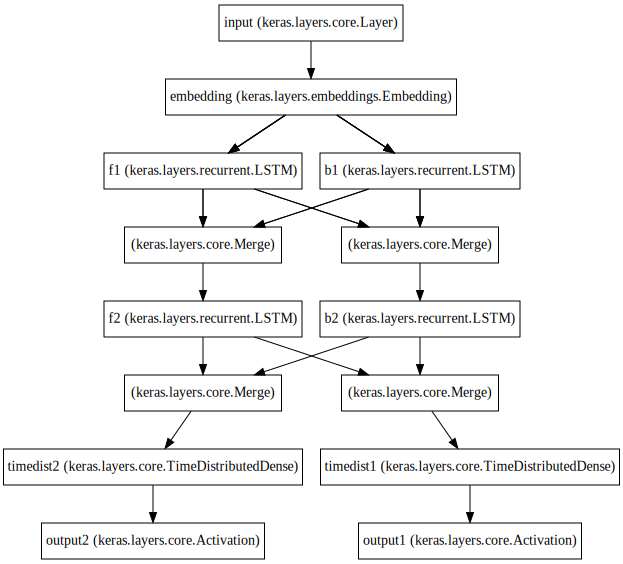

In [9]:
from IPython.display import SVG
from keras.utils.visualize_util import to_graph

SVG(to_graph(model).create(prog='dot', format='svg'))

# Test the embedding layer result
Hint: To test you need to change the context_win=2, input_length=3 

In [13]:

from keras import backend as K
tmp = model.layers[:]
model.layers = model.layers[0:1]
X1 = np.array([[[0,1],[3,2],[2,3]],[[1,2],[0,2],[1,3]]], dtype='int32')
Y =K.eval(model(K.variable(X1,dtype='int32')))
print (Y.shape)

(2, 3, 10)


In [10]:
from keras.callbacks import EarlyStopping

rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
#model.compile(loss='categorical_crossentropy', optimizer=rms)
model.compile(loss={'output1':'categorical_crossentropy','output2':'categorical_crossentropy'}, optimizer=rms)
earlyStopping=EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')


In [140]:

#X_train=map(lambda x:contextwin(x,5), X_train[0:1])
#X_train= contextwin(x,5) for x in X_train[0:1]

cx_train=np.array([contextwin(x,context_win) for x in X_train],np.int32)
cx_test=np.array([contextwin(x,context_win) for x in X_test],np.int32)

print (cx_train.shape, Y_train.shape, cx_test.shape)



(8000, 100, 7) (8000, 100, 42) (934, 100, 7)


In [17]:
print( X_train.shape,Y_train.shape)


(8000, 100) (8000, 100, 40)


In [11]:
model.fit({'input':X_train, 'output1': Y1_train,'output2':Y2_train}, batch_size=20, nb_epoch=50, callbacks=[earlyStopping],validation_split=0.1)
                                                                                    

#model.fit(cx_train, cy_train, batch_size=2, nb_epoch=100, show_accuracy=True, verbose=2)


Train on 7200 samples, validate on 800 samples
Epoch 1/50
7200/7200 [==============================] - 520s - loss: 0.3276 - val_loss: 0.1965
Epoch 2/50
7200/7200 [==============================] - 515s - loss: 0.1872 - val_loss: 0.1952
Epoch 3/50
7200/7200 [==============================] - 498s - loss: 0.1846 - val_loss: 0.1922
Epoch 4/50
7200/7200 [==============================] - 497s - loss: 0.1838 - val_loss: 0.1929
Epoch 5/50
7200/7200 [==============================] - 498s - loss: 0.1834 - val_loss: 0.1940
Epoch 6/50
7200/7200 [==============================] - 497s - loss: 0.1829 - val_loss: 0.1911
Epoch 7/50
7200/7200 [==============================] - 497s - loss: 0.1826 - val_loss: 0.1931
Epoch 8/50
7200/7200 [==============================] - 497s - loss: 0.1820 - val_loss: 0.1919
Epoch 9/50
7200/7200 [==============================] - 497s - loss: 0.1813 - val_loss: 0.1893
Epoch 10/50
7200/7200 [==============================] - 498s - loss: 0.1791 - val_loss: 0.1836
Ep

In [142]:
predicted=model.predict(cx_train)
predicted



934/934 [==============================] - 25s    


In [12]:
model.save_weights('joint-2layer_biLSTM_50dim_128hd_model_weights.h5')

In [13]:
score = model.evaluate({'input':X_train, 'output1':Y1_train,'output2':Y2_train},batch_size=20, verbose=1)
score

8000/8000 [==============================] - 117s   


0.09095366841182112

In [20]:
res = model.predict({'input':X_train})


In [21]:
res2=res['output2'].argmax(axis=-1)

In [150]:
Y_test[1]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [22]:
groundtruth_test=[map(lambda x: idx2la_2[x], y) for y in train_labels_2]




In [23]:
res2=[[x for x in y if x!= 0] for y in res2]
pred=[map(lambda x:idx2la_2[x], y) for y in res2]
words_test = [map(lambda x: idx2w[x], w) for w in train_dataset]

In [24]:
for ws, s, sp in zip(words_test, groundtruth_test , pred):
    print('\n')
    for wl, sl, wp in zip(ws, s, sp):
          print (wl+' ' + sl + ' ' + wp + '\n')



the O O

system O O

as O O

described O O

above O O

has O O

its O O

greatest O O

application O O

in O O

an O O

<UNK> O O

configuration B+Whole B+Effect

of O O

antenna O O

elements B+Component B+Member

. O O



the O O

child B+Other_1 O

was O O

carefully O O

wrapped O O

and O O

bound O O

into O O

the O O

cradle B+Other_2 B+Container

by O O

means O O

of O O

a O O

cord O O

. O O



the O O

author B+Agency B+Other_1

of O O

a O O

<UNK> O O

uses O O

a O O

<UNK> B+Instrument O

to O O

look O O

at O O

the O O

raw O O

assembly O O

code O O

. O O



a O O

<UNK> O O

<UNK> B+Other_1 O

uprises O O

from O O

the O O

surge B+Other_2 B+Destination

. O O



the O O

student B+Member O

association B+Collection O

is O O

the O O

voice O O

of O O

the O O

undergraduate O O

student O O

population O O

of O O

the O O

state O O

university O O

of O O

new O O

york O O

at O O

<UNK> O O

. O O



this O O

is O O

the O O

<UNK> O O

complex B+Oth

In [42]:
# utils functions
def shuffle(lol, seed):
    '''
    lol :: list of list as input
    seed :: seed the shuffling
    shuffle inplace each list in the same order
    '''
    for l in lol:
        random.seed(seed)
        random.shuffle(l)

In [22]:
# metrics function using conlleval.pl
def conlleval(p, g, w, filename, script_path):
    '''
    INPUT:
    p :: predictions
    g :: groundtruth
    w :: corresponding words
    OUTPUT:
    filename :: name of the file where the predictions
    are written. it will be the input of conlleval.pl script
    for computing the performance in terms of precision
    recall and f1 score
    OTHER:
    script_path :: path to the directory containing the
    conlleval.pl script
    '''
    out = ''
    for sl, sp, sw in zip(g, p, w):
        out += 'BOS O O\n'
        for wl, wp, w in zip(sl, sp, sw):
            out += w + ' ' + wl + ' ' + wp + '\n'
        out += 'EOS O O\n\n'

    f = open(filename, 'w')
    f.writelines(out)
    f.close()

    return get_perf(filename, script_path)

def download(origin, destination):
    '''
    download the corresponding atis file
    from http://www-etud.iro.umontreal.ca/~mesnilgr/atis/
    '''
    print ('Downloading data from %s' % origin)
    urllib.urlretrieve(origin, destination)

def get_perf(filename, folder):
    ''' run conlleval.pl perl script to obtain
    precision/recall and F1 score '''
    _conlleval = os.path.join(folder, 'conlleval.pl')
    if not os.path.isfile(_conlleval):
        url = 'https://www.comp.nus.edu.sg/%7Ekanmy/courses/practicalNLP_2008/packages/conlleval.pl'
        download(url, _conlleval)
        os.chmod(_conlleval, stat.S_IRWXU)  # give the execute permissions

    proc = subprocess.Popen(["perl",
                            _conlleval],
                            stdin=subprocess.PIPE,
                            stdout=subprocess.PIPE)

    stdout, _ = proc.communicate(''.join(open(filename).readlines()))
    for line in stdout.split('\n'):
        if 'accuracy' in line:
            out = line.split()
            break
     
    precision = float(out[3][:-2])
    recall = float(out[5][:-2])
    f1score = float(out[7])
    print (out)
    return {'p': precision, 'r': recall, 'f1': f1score}

In [23]:
folder = "relationExtraction/RelationExtraction"
res_test = conlleval(pred, groundtruth_test, words_test,folder + '/current.test.txt', folder)

['accuracy:', '90.02%;', 'precision:', '0.00%;', 'recall:', '0.00%;', 'FB1:', '0.00']


In [45]:
res_test

{'f1': 0.0, 'p': 0.0, 'r': 0.0}

In [ ]:
if __name__ == "__main__":
    n_folds = 5
    data, labels = load_data()
    skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

    for i, (train, test) in enumerate(skf):
            print "Running Fold", i+1, "/", n_folds
            model = None # Clearing the NN.
            model = create_model()
            train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test))